C:\Users\TTKT\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


data loaded


C:\Users\TTKT\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:43:06] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


=== XGBoost Performance ===
Accuracy:  0.987
Precision: 0.190
Recall:    0.762
F1 Score:  0.304
ROC AUC:   0.973


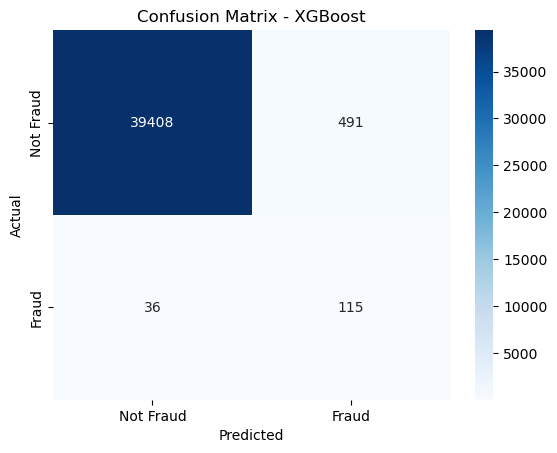

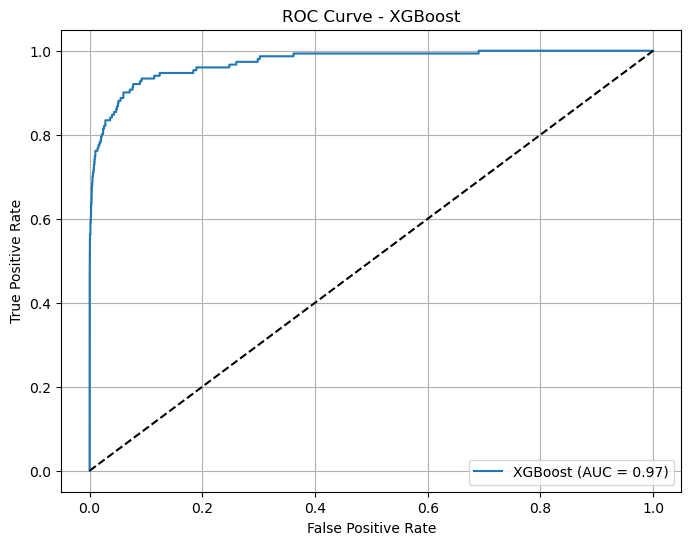

In [1]:
# STEP 1: Import Required Libraries
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier

# STEP 2: Load and Prepare Data (as before)
users = pd.read_csv(r"C:\Users\TTKT\Downloads\FDA Final\users.csv")           
transactions = pd.read_csv(r"C:\Users\TTKT\Downloads\FDA Final\transactions.csv")  
fraudsters = pd.read_csv(r"C:\Users\TTKT\Downloads\FDA Final\fraudsters.csv")  
print("data loaded")
fraud_ids = set(fraudsters['USER_ID'])

txn_grp = transactions.groupby('USER_ID')
user_features = txn_grp.agg(
    trans_count=('ID', 'count'),
    total_amount=('AMOUNT_GBP', 'sum'),
    avg_amount=('AMOUNT_GBP', 'mean'),
    failed_count=('STATE', lambda x: (x == 'FAILED').sum()),
    currency_count=('CURRENCY', pd.Series.nunique)
).reset_index()
user_features['fail_rate'] = user_features['failed_count'] / user_features['trans_count']

type_dummies = pd.get_dummies(transactions['TYPE'])
type_counts = transactions[['USER_ID']].join(type_dummies).groupby('USER_ID').sum().reset_index()

features = pd.merge(user_features, type_counts, on='USER_ID', how='left')
features = pd.merge(features, users, left_on='USER_ID', right_on='ID', how='left')
today = datetime(2025, 5, 15)
features['CREATED_DATE'] = pd.to_datetime(features['CREATED_DATE'], errors='coerce')
features['BIRTH_DATE'] = pd.to_datetime(features['BIRTH_DATE'], errors='coerce')
features['account_age_days'] = (today - features['CREATED_DATE']).dt.days
features['user_age'] = ((today - features['BIRTH_DATE']).dt.days / 365).astype(int)
features.drop(['CREATED_DATE', 'BIRTH_DATE', 'ID'], axis=1, inplace=True)
features = pd.get_dummies(features, columns=['COUNTRY'], prefix='Country')
features['is_fraud'] = features['USER_ID'].isin(fraud_ids).astype(int)
features.drop('USER_ID', axis=1, inplace=True)

# STEP 3: Train-Test Split and Scaling
X = features.drop('is_fraud', axis=1)
y = features['is_fraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# STEP 4: Train XGBoost Model
xgb = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=7,
    scale_pos_weight=(len(y_train)-sum(y_train))/sum(y_train),  # handles imbalance
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
xgb.fit(X_train_scaled, y_train)

# STEP 5: Predictions and Evaluation
y_pred = xgb.predict(X_test_scaled)
y_proba = xgb.predict_proba(X_test_scaled)[:, 1]

print("=== XGBoost Performance ===")
print(f"Accuracy:  {accuracy_score(y_test, y_pred):.3f}")
print(f"Precision: {precision_score(y_test, y_pred):.3f}")
print(f"Recall:    {recall_score(y_test, y_pred):.3f}")
print(f"F1 Score:  {f1_score(y_test, y_pred):.3f}")
print(f"ROC AUC:   {roc_auc_score(y_test, y_proba):.3f}")

# STEP 6: Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.title("Confusion Matrix - XGBoost")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# STEP 7: ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"XGBoost (AUC = {roc_auc_score(y_test, y_proba):.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - XGBoost")
plt.legend()
plt.grid(True)
plt.show()
